―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.topotools.topotools._scale_3d_axes 
    TIME STAMP: 2020-08-16 10:31:37,356    


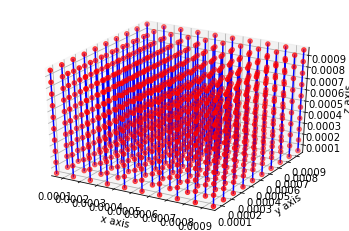

In [3]:
%reset -f 
# clear variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import openpnm as op
import matplotlib.pyplot as plt
import scipy as sp
import openpnm.models as mods
import openpnm.io.VTK as iovtk

# add cubic pnm model
pn = op.network.Cubic(shape=[10, 10, 10], spacing=0.0001)

# add geometry model
geo = op.geometry.GenericGeometry(network=pn, pores=pn.pores(),
                                  throats=pn.throats(), name='geo')


# diameter distribution
geo.add_model(propname='pore.seed',
             model=mods.misc.random,
             element='pore',
             num_range=[0.2, 0.7],
             seed=None)

geo.add_model(propname='pore.max_size',
                       model=mods.geometry.pore_size.largest_sphere,
                       iters=10)

geo.add_model(propname='pore.diameter',
             model=mods.misc.product,
             prop1='pore.max_size',
             prop2='pore.seed')

# assign pore diameter
geo['pore.diameter'] =  5.00E-05

# exclude throats not in z-axis direction
op.topotools.trim(network=pn, throats=pn.throats()[900:])

# quick plot, check if only z-axis throats are kept
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores(), c='r')
fig = op.topotools.plot_connections(network=pn, throats=pn.throats(), fig=fig, c='b')

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.algorithms.GenericTransport._get_domain_area 
    TIME STAMP: 2020-08-16 10:31:41,757    
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.algorithms.GenericTransport._get_domain_length 
    TIME STAMP: 2020-08-16 10:31:41,762    


300
{'K_diy': array([4.00001615e-12]),
 'K_op1': array([4.93829154e-12]),
 'K_op2': 4.00002e-12,
 'Q1': array([4.97593756e-07]),
 'Q2': array([-4.97593756e-07])}
[100000.         102897.33901421 105794.67802842 133333.33333333
 136230.67234754 163769.32765246 166666.66666667 194205.32197158
 197102.66098579 200000.        ]
[0.289734 0.289734 2.753866 0.289734 2.753866 0.289734 2.753866 0.289734
 0.289734]


Text(0.5, 0, 'flow channel distance (* 0.1 mm)')

Text(0, 0.5, 'pressure (* 10$^5$ Pa)')

Text(0, 0.5, 'pressure gradient (* 10$^8$ Pa/m)')

Text(0.5, 1.0, 'permeability: 4.00002e-12 m$^2$')

(0.6, 2.2)

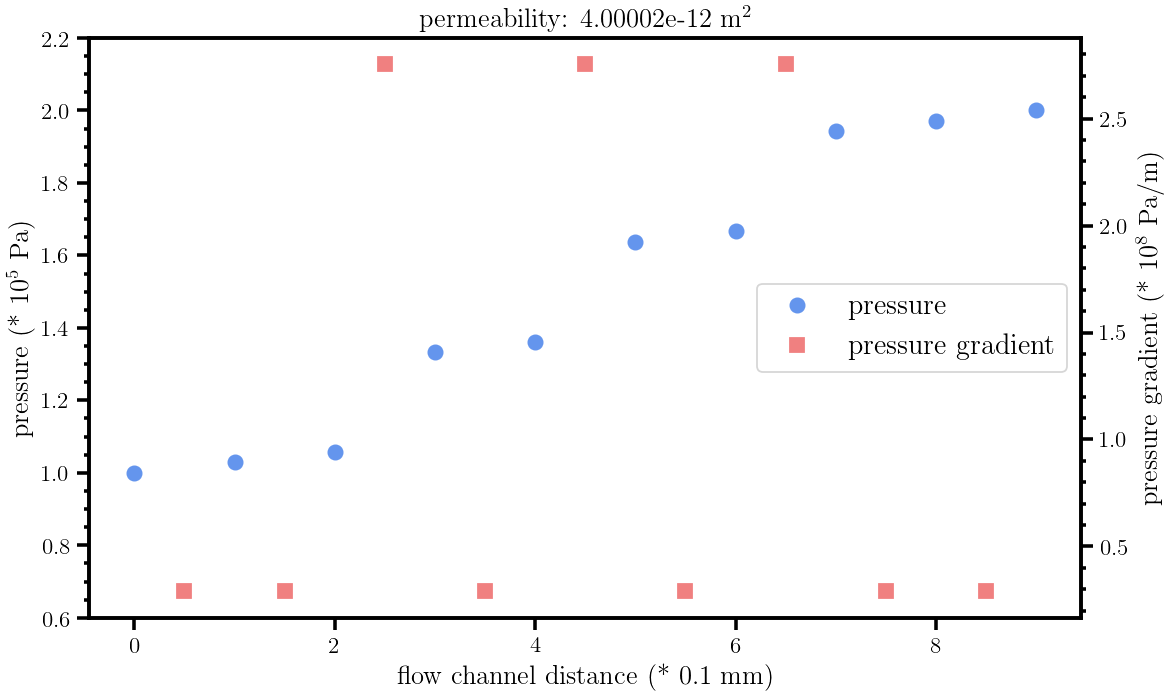

In [4]:
# add throats
geo.add_model(propname='throat.diameter',
              model=mods.geometry.throat_size.from_neighbor_pores,
              pore_prop='pore.diameter',
              mode='min')

#-------------------------------------------------------------
for to in geo.throats():
    if (to % 9)==2:
        geo['throat.diameter'][to] = 2.50E-05
        
for to in geo.throats():
    if (to % 9)==4:
        geo['throat.diameter'][to] = 2.50E-05
        
for to in geo.throats():
    if (to % 9)==6:
        geo['throat.diameter'][to] = 2.50E-05
        
# file name
f_name = '.\\unidirectional\\throat-2-4-6'
        
# count the number of throats with diameter of 2.50E-05 m
i = 0
for thr in geo['throat.diameter']:
    if thr==2.50E-05:
        i += 1

print(i)
#----------------------------------------------------------------

# add other necessary properties

geo.add_model(propname='pore.area',
              model=mods.geometry.pore_area.sphere)

geo.add_model(propname='pore.volume',
              model=mods.geometry.pore_volume.sphere)

geo.add_model(propname='throat.endpoints',
              model=mods.geometry.throat_endpoints.spherical_pores,
              pore_diameter='pore.diameter',
              throat_diameter='throat.diameter')

geo.add_model(propname='throat.conduit_lengths',
              model=mods.geometry.throat_length.conduit_lengths,
              throat_endpoints='throat.endpoints',
              throat_length='throat.length')

geo.add_model(propname='throat.length',
              model=mods.geometry.throat_length.piecewise)

geo.add_model(propname='throat.volume',
              model=mods.geometry.throat_volume.cylinder)

geo.add_model(propname='throat.area',
              model=mods.geometry.throat_area.cylinder)

geo.add_model(propname='throat.surface_area',
              model=mods.geometry.throat_surface_area.cylinder)

geo['throat.radius'] = geo['throat.diameter'] / 2

# phase
water = op.phases.Water(network=pn)

water.add_model(propname='throat.hydraulic_conductance',
                model=op.models.physics.hydraulic_conductance.hagen_poiseuille)

# stokesflow simulation
flow = op.algorithms.StokesFlow(network=pn, phase=water)
flow.set_value_BC(pores=pn.pores('top'), values=200000)
flow.set_value_BC(pores=pn.pores('bottom'), values=100000)
flow.setup(phase= water, quantity='pore.pressure', conductance='throat.hydraulic_conductance')

flow.run()  # after this line, pore pressures are calculated

Q1 = flow.rate(pores=geo.pores('top'))
Q2 = flow.rate(pores=geo.pores('bottom'))
K_diy = Q1*water['pore.viscosity'].mean()*(0.0009)/((0.001**2)*100000)

K_op1 = flow.calc_effective_permeability(inlets=geo.pores('top'), outlets=geo.pores('bottom'),
                                    domain_area=None, domain_length=None)

K_op2 = flow.calc_effective_permeability(inlets=geo.pores('top'), outlets=geo.pores('bottom'),
                                    domain_area=0.001**2, domain_length=0.0009)

K_op2 = np.around(K_op2[0], decimals=17)

check_1 = {'Q1': Q1,
           'Q2': Q2,
           'K_diy': K_diy,
           'K_op1': K_op1,
           'K_op2': K_op2}

# check data
import pprint
pprint.pprint(check_1)


# extract pressure distribution at one channel
pre = flow['pore.pressure'][:10]
print(pre)


pre = pre / 100000

# calculate pressrue gradient
throat_index = np.arange(9) + 0.5
pre_gra = np.array([(pre[i]-pre[i-1])/0.1 for i in range(1,10)])
pre_gra = np.round(pre_gra, decimals=6)  
print(pre_gra)

# plot
import matplotlib.pyplot as plt

z = np.arange(10)

#plt.style.use(['ager','scatter'])

fig, ax1 = plt.subplots(figsize=(10, 6), dpi=128)
ax2 = ax1.twinx()

# pressrue distribution
p1, = ax1.plot(z, pre, c='cornflowerblue', ms='8')
ax1.set_xlabel('flow channel distance (* 0.1 mm)', fontsize=15)
ax1.set_ylabel('pressure (* 10$^5$ Pa)', fontsize=15, verticalalignment='bottom')
ax1.xaxis.set_minor_locator(plt.NullLocator())

# common x-axis, for pressure gradient
p2, = ax2.plot(throat_index, pre_gra, marker='s', c='lightcoral', ms='8')
ax2.set_ylabel('pressure gradient (* 10$^8$ Pa/m)', fontsize=15)
#ax2.set_yscale('log')
ax2.xaxis.set_minor_locator(plt.NullLocator())

plt.title('permeability: '+str(K_op2)+' m$^2$', fontsize=15)  # 改标题

plt.legend((p1, p2),('pressure','pressure gradient'), loc='center right', frameon=True, prop = {'size':16})

ax1.tick_params(labelsize=13)
ax2.tick_params(axis='y', labelsize=13)

ax1.set_ylim(0.6, 2.2)
#ax2.set_ylim(0, 6)

#plt.savefig(f_name+'.png')  
plt.show()

# save data to file
pre_gra = np.append(pre_gra, 0)
#np.savetxt(f_name+'.txt', np.column_stack((pre, pre_gra)))

# save PNM file for visualization in paraview
#op.io.VTK.save(network=pn, phases=[flow], filename=f_name, delim='|', fill_nans=0)  